# Extract and Transform
**Author:** Michael McCann<br>
**Last Update:** 25 MAY 2020

<u>Overview:</u> <br>
We have been asked to pull data from IMDB in order to create a movie database for future hypothesis testing and regression modeling. 
 
<u>Tasks:</u><br> 
- Downloading data straight from IMDB 
- inspecting/cleaning the data
- Save data locally for future use

<u>References:</u><br>
IMDB Data: https://datasets.imdbws.com <br>
IMDB Data Dictionary: https://www.imdb.com/interfaces/ <br>
TMDB API: https://developers.themoviedb.org/4/getting-started/authorization <br>
TMDP API Package: https://github.com/celiao/tmdbsimple

<u>Overview:</u> <br>
The [IMDB data](https://github.com/msmccann10/PP-movie-database-and-analysis/blob/main/01_IMDB_Data_Loading_and_Processing.ipynb) does not include financial information (budget/revenue) or MPAA certification. [The Movie Database (TMDB)](https://www.themoviedb.org/) is another database that contains this information and is accessible via API call. We will access the API to get additional data to make our database.
 
<u>Tasks:</u><br> 
- Make folders/location to save data
- Build and run API for TMDB
- Remove unwanted files

<u>Overview:</u> <br>
Our [API call](https://github.com/msmccann10/PP-movie-database-and-analysis/blob/main/02_TMDB_API_Pull.ipynb) resulted in 21 CSVs for each year in which we were interested. However, to do any analysis we will need to pull these together into one DataFrame. We will also take an initial look at some of the TMDB data.

<u>Tasks:</u><br> 
- Merge TMDB data into one DataFrame
- Light cleaning for initial EDA
 - additional cleaning and column selection will be done prior to database creation.
- Save merged DataFrame, remove individual CSVs
- Initial EDA

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json, os, math, time

import tmdbsimple as tmdb
from tqdm.notebook import tqdm_notebook

## Functions

### Movie Ratings Function

In [6]:
def movie_rating(movie_id):
    movie = tmdb.Movies(movie_id)
    info = movie.info()
    releases = movie.releases()
        
    for c in releases['countries']:
        if c['iso_3166_1'] == 'US':
            info['certification'] = c['certification']
    return info

### Write JSON function

In [7]:
def write_json(new_data, filename): 
    with open(filename,'r+') as file:
    # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

# EXTRACT - IMDB Dataset

## Data

### Extract Raw Data, Save for Local Use
Save to data folder in repository
Code here for reference but not needed going forward...

In [3]:
## Create Folder in repo for data storage
FOLDER = "Data/"

os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['title_akas.csv.gz', 'title_basics.csv.gz', 'title_ratings.csv.gz']

In [2]:
# Filepaths
basics_url = 'https://datasets.imdbws.com/title.basics.tsv.gz'
akas_url = 'https://datasets.imdbws.com/title.akas.tsv.gz'
ratings_url = 'https://datasets.imdbws.com/title.ratings.tsv.gz'

# Read in Dataframe
basics = pd.read_csv(basics_url, sep='\t', low_memory = False)
akas = pd.read_csv(akas_url, sep='\t', low_memory = False)
ratings = pd.read_csv(ratings_url, sep='\t', low_memory = False)

# Save locally for future use
basics.to_csv("data/title_basics.csv.gz",compression='gzip',index=False)
akas.to_csv("data/title_akas.csv.gz",compression='gzip',index=False)
ratings.to_csv("data/title_ratings.csv.gz",compression='gzip',index=False)

### Load for Use

In [3]:
basics = pd.read_csv("data/title_basics.csv.gz", low_memory = False)
akas = pd.read_csv("data/title_akas.csv.gz", low_memory = False)
ratings = pd.read_csv("data/title_ratings.csv.gz", low_memory = False)

# TRANSFORM - IMDB DATA

### Ratings DF

In [4]:
display(ratings.head(2))
print('\n')
ratings.info()

tconst  averageRating  numVotes
0  tt0000001            5.7      1874
1  tt0000002            5.9       248



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1237390 entries, 0 to 1237389
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1237390 non-null  object 
 1   averageRating  1237390 non-null  float64
 2   numVotes       1237390 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 28.3+ MB


In [7]:
# Replace '\n' with NaN
ratings = ratings.replace({'\\N':np.nan})

### AKAs DF

In [5]:
display(akas.head(2))
print('\n')
akas.info()

titleId  ordering                   title region language        types  \
0  tt0000001         6              Carmencita     US      NaN  imdbDisplay   
1  tt0000002         7  The Clown and His Dogs     US      NaN          NaN   

              attributes  isOriginalTitle  
0                    NaN              0.0  
1  literal English title              0.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1316473 entries, 0 to 1316472
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   titleId          1316473 non-null  object 
 1   ordering         1316473 non-null  int64  
 2   title            1316473 non-null  object 
 3   region           1316473 non-null  object 
 4   language         3507 non-null     object 
 5   types            1023430 non-null  object 
 6   attributes       43841 non-null    object 
 7   isOriginalTitle  1315098 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 80.4+ MB


In [8]:
# Replace '\n' with NaN
akas = akas.replace({'\\N':np.nan})

In [9]:
akas = akas[akas['region'] == 'US']

### Basics DF

In [10]:
display(basics.head(2))
print('\n')
basics.info()

tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short          Pauvre Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

  isAdult startYear endYear runtimeMinutes                    genres  
0       0      1894      \N              1         Documentary,Short  
1       0      1892      \N              5           Animation,Short  
2       0      1892      \N              4  Animation,Comedy,Romance  
3       0      1892      \N             12           Animation,Short  
4       0      1893      \N              1              Comedy,Short




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8870622 entries, 0 to 8870621
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         object
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: object(9)
memory usage: 609.1+ MB


In [11]:
# Replace '\n' with NaN
basics = basics.replace({'\\N':np.nan})

In [13]:
# Filter and Clean
genre_notna = basics['genres'].notna() #drop rows from genre w NaN
runtime_notna = basics['runtimeMinutes'].notna() #drop rows from runtime w NaN
type_movie = basics['titleType'] == 'movie' # select movie type
after2000 = basics['startYear'] >= '2000' # select years after 2000
before2022 = basics['startYear'] <= '2021'# select years before 2022

basics = basics[genre_notna & runtime_notna & type_movie & after2000 & before2022]

is_documentary = basics['genres'].str.contains('documentary',case=False)
basics = basics[~is_documentary]

In [14]:
keepers =basics['tconst'].isin(akas['titleId'])
basics = basics[keepers]
basics.head(2)

tconst titleType  \
34805    tt0035423     movie   
61119    tt0062336     movie   
67672    tt0069049     movie   
86806    tt0088751     movie   
91077    tt0093119     movie   
...            ...       ...   
8869758  tt9914942     movie   
8870154  tt9915872     movie   
8870294  tt9916170     movie   
8870303  tt9916190     movie   
8870387  tt9916362     movie   

                                              primaryTitle  \
34805                                       Kate & Leopold   
61119    The Tango of the Widower and Its Distorting Mi...   
67672                           The Other Side of the Wind   
86806                                    The Naked Monster   
91077                                  Grizzly II: Revenge   
...                                                    ...   
8869758                             Life Without Sara Amat   
8870154                               The Last White Witch   
8870294                                      The Rehearsal   
8870303                                          Safeguard   
8870387                                              Coven   

                                     originalTitle isAdult startYear endYear  \
34805                               Kate & Leopold       0      2001     NaN   
61119    El Tango del Viudo y Su Espejo Deformante       0      2020     NaN   
67672                   The Other Side of the Wind       0      2018     NaN   
86806                            The Naked Monster       0      2005     NaN   
91077                     Grizzly II: The Predator       0      2020     NaN   
...                                            ...     ...       ...     ...   
8869758                 La vida sense la Sara Amat       0      2019     NaN   
8870154                  My Girlfriend is a Wizard       0      2019     NaN   
8870294                                   O Ensaio       0      2019     NaN   
8870303                                  Safeguard       0      2020     NaN   
8870387                                   Akelarre       0      2020     NaN   

        runtimeMinutes                     genres  
34805              118     Comedy,Fantasy,Romance  
61119               70                      Drama  
67672              122                      Drama  
86806              100       Comedy,Horror,Sci-Fi  
91077               74      Horror,Music,Thriller  
...                ...                        ...  
8869758             74                      Drama  
8870154             97       Comedy,Drama,Fantasy  
8870294             51                      Drama  
8870303             90  Action,Adventure,Thriller  
8870387             92              Drama,History  

[79185 rows x 9 columns]

# EXTRACT - TMDB API PULL

## Get API Key

In [5]:
# Get filepath for keys
file = "../../.secret/tmdb_api.json"

# load keys as login
with open(file, 'r') as f:
    login = json.load(f)

## Instantiate API

In [ ]:
# Instantiate API
tmdb.API_KEY = login['api-key']

## API Call

In [ ]:
## Set Years we are interested in
YEARS_TO_GET = list(range(2000,2022))

In [6]:
### COMMENTED OUT TO KEEP FROM ACCIDENTLY RUNNING THIS!!!! ### 

## API Call Function
# for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position = 0):    
#     JSON_FILE = f'{FOLDER}tmdb_api_requests_{YEAR}.json'
    
#     # Check for JSON_FILE
#     file_exists = os.path.isfile(JSON_FILE)

#     # If it does not exist create a blank one for use
#     if file_exists == False:
#         with open(JSON_FILE, 'w') as f:
#             json.dump([{'imdb_id':0}],f)
    
#     # get movie ids ('tconst') from our IMDB basics dataframe
#     df = basics.loc[basics['startYear'] == YEAR].copy()
#     movie_ids = df['tconst'].copy()
    
#     # Check for previous pulls 
#     previous_df = pd.read_json(JSON_FILE)
#     movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]
    
#     for movie_id in tqdm_notebook(movie_ids_to_get,
#                              desc=f'Movies from {YEAR}',
#                              position = 1,
#                              leave = True):
#             try:
#                 temp = movie_rating(movie_id)
#                 write_json(temp, JSON_FILE)
#                 time.sleep(0.02)

#             except Exception as e:
#                     continue
    
#     # Save the results out to a zipped csv                
#     final_year_df = pd.read_json(JSON_FILE)
#     final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip", index=False)

YEARS:   0%|          | 0/22 [00:00<?, ?it/s]

Movies from 2000:   0%|          | 0/207 [00:00<?, ?it/s]

Movies from 2001:   0%|          | 0/241 [00:00<?, ?it/s]

Movies from 2002:   0%|          | 0/1505 [00:00<?, ?it/s]

Movies from 2003:   0%|          | 0/1630 [00:00<?, ?it/s]

Movies from 2004:   0%|          | 0/1832 [00:00<?, ?it/s]

Movies from 2005:   0%|          | 0/2124 [00:00<?, ?it/s]

Movies from 2006:   0%|          | 0/2347 [00:00<?, ?it/s]

Movies from 2007:   0%|          | 0/2483 [00:00<?, ?it/s]

Movies from 2008:   0%|          | 0/2823 [00:00<?, ?it/s]

Movies from 2009:   0%|          | 0/3450 [00:00<?, ?it/s]

Movies from 2010:   0%|          | 0/3750 [00:00<?, ?it/s]

Movies from 2011:   0%|          | 0/4143 [00:00<?, ?it/s]

Movies from 2012:   0%|          | 0/4426 [00:00<?, ?it/s]

Movies from 2013:   0%|          | 0/4620 [00:00<?, ?it/s]

Movies from 2014:   0%|          | 0/4771 [00:00<?, ?it/s]

Movies from 2015:   0%|          | 0/4934 [00:00<?, ?it/s]

Movies from 2016:   0%|          | 0/5147 [00:00<?, ?it/s]

Movies from 2017:   0%|          | 0/5509 [00:00<?, ?it/s]

Movies from 2018:   0%|          | 0/5629 [00:00<?, ?it/s]

Movies from 2019:   0%|          | 0/5676 [00:00<?, ?it/s]

Movies from 2020:   0%|          | 0/4766 [00:00<?, ?it/s]

Movies from 2021:   0%|          | 0/4700 [00:00<?, ?it/s]

# TRANSFORM

## TMDB - Merge CSVs and Clean


### Merge
Load the results from our API call (years 2000 - 2021) and concatenate them into one DataFrame.

**Note:** This section is commented out and remains for documentation purposes. After running thie script we save the merged DataFrame and delete the individual CSVs and JSON files. See below to load in the merged DF. 

In [2]:
YEARS = list(range(2000,2022))

tmdb_merged = pd.DataFrame({})

for YEAR in YEARS:
    filepath = f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz"
    temp = pd.read_csv(filepath)
    tmdb_merged = pd.concat([tmdb_merged, temp], ignore_index = True)
    
    print(f'Year {year} added {temp.shape[0]} new rows to our dataframe. New Total: {tmdb_merged.shape[0]}')
    print('-----')

### Cleaning
Initial Cleaning prior to saving the DataFrame.

**Note:** This sections have been commented out as they were done PRIOR to saving the DataFrame. 

In [4]:
# display(tmdb_merged.head(2))
# print('\n')
# tmdb_merged.info()

In [5]:
# # Each DF loaded in has a first column with an IMDB ID equal to zero. 
# # This is from creating the file to save the API and should be removed. 
# tmdb_merged = tmdb_merged[tmdb_merged['imdb_id'] != '0']

In [6]:
# # Checking the certifications as that was one of the columns we were missing.
# tmdb_merged['certification'].unique()

In [7]:
# # Clean up the certifications
# replace_nr = {'Unrated':'UR', 'Not Rated': 'NR', '10':'NR', '-': 'NR',
#         'ScreamFest Horror Film Festival': 'NR'} 
# tmdb_merged['certification'] = tmdb_merged['certification'].str.strip()
# tmdb_merged['certification'] = tmdb_merged['certification'].replace(replace_nr)

In [8]:
# # Clean up the 'belongs_to_collection' column to indicate if it does/does not belong in a collection.
# tmdb_merged['belongs_to_collection'] = tmdb_merged['belongs_to_collection'].notna().astype(int)

# Remove Extra Files
Our JSON files have been made into csv.gz files. Likewise, these csv.gz files have been merged into a single csv.gz file...  We do not need to keep these files as they are just taking up extra space and can be deleted. 

**Note:** This section is commented out to keep anyone from deleting files they might want to keep. Only run if you are willing/able to remove the non-merged csvs and JSON files.

In [3]:
## Loop through and remove JSON files created above.
# for YEAR in YEARS_TO_GET:
#     if os.path.exists(f'{FOLDER}tmdb_api_requests_{YEAR}.json'):
#         os.remove(f'{FOLDER}tmdb_api_requests_{YEAR}.json')
#     else:
#         print (f"file {FOLDER}tmdb_api_requests_{YEAR}.json does not exist")

## Loop through and remove JSON files created above.
# for YEAR in YEARS:
#     if os.path.exists(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz"):
#         os.remove(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz")
#         print(f'file {FOLDER}final_tmdb_data_{YEAR}.csv.gz removed')
#     else:
#         print(f'file {FOLDER}final_tmdb_data_{YEAR}.csv.gz does not exist')

# Save Cleaned DataFrames
Save out IMDB and TMDB DataFrames for use in EDA, Database Creation, Hypothesis Testing, and Modeling

In [ ]:
## Save out DF for use in other steps
# tmdb_merged.to_csv(f"data/tmdb_merged.csv.gz", compression="gzip", index=False)
basics.to_csv("data/title_basics.csv.gz",compression='gzip',index=False)
akas.to_csv("data/title_akas.csv.gz",compression='gzip',index=False)
ratings.to_csv("data/title_ratings.csv.gz",compression='gzip',index=False)

# EDA

In [85]:
# Load in data
tmdb_merged = pd.read_csv("data/tmdb_merged.csv.gz")

In [11]:
# Make a copy for visualization purposes
tmdb_viz = tmdb_merged.copy()

In [12]:
# For this initial EDA we were asked to eliminate variables other than revenue, budget, and certification:
tmdb_merged = tmdb_merged[['imdb_id', 'revenue', 'budget', 'certification']]

In [13]:
# Our stakeholder has expressed an interest in seeing only 'rated' movies budgets/revenue for comparison.
nr = tmdb_viz['certification'] == 'NR'
unrated = tmdb_viz['certification'] == 'Unrated'
nc17 = tmdb_viz['certification'] == 'NC-17'

tmdb_viz = tmdb_viz[~(nr | unrated | nc17)]
tmdb_viz.dropna(subset= ['certification'], inplace = True)

In [14]:
# Lets see what our dataset has in terms of budget/revenue data
budget = tmdb_viz['budget'] > 0
revenue = tmdb_viz['revenue'] > 0
either = tmdb_viz[budget | revenue]

print(f'{budget.sum()} rows have budget information.')
print(f'{revenue.sum()} rows have revenue information.')
print(f'{either["imdb_id"].count()} rows have either budget OR revenue information.')

5096 rows have budget information.
4781 rows have revenue information.
6113 rows have either budget OR revenue information.


In [15]:
# Grab movies with either budget OR revenue information available.
tmdb_viz = tmdb_viz[budget | revenue]

### Viz: Distriubution by Rating

In [16]:
## Set certification to a categorical ordering
tmdb_viz['certification'] = pd.Categorical(tmdb_viz['certification'],
                                           ['G','PG','PG-13','R'])

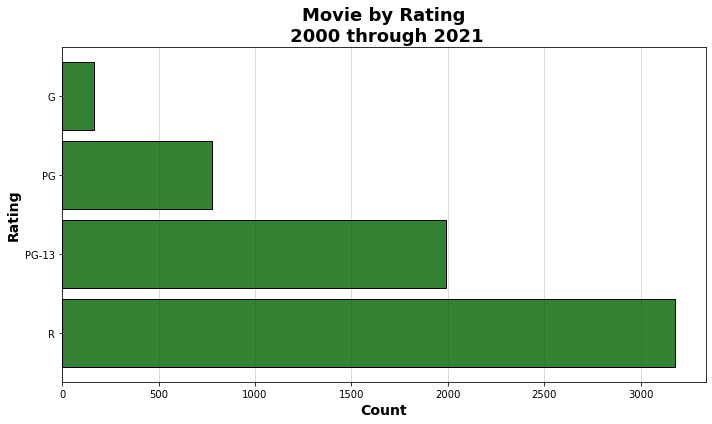

In [17]:
## Visualize Distribution by Rating
fig, ax = plt.subplots(figsize = (10,6))
sns.histplot(y = tmdb_viz['certification'], 
             color = "#006400", alpha = .8, shrink = .85)
plt.title('Movie by Rating\n 2000 through 2021', 
             fontsize = 18, weight = 'bold')
plt.xlabel('Count', fontsize=14, weight = 'semibold')
plt.ylabel('Rating',  fontsize=14, weight = 'semibold')
plt.grid(axis = 'x', alpha = .6)
ax.set_axisbelow(True)
fig.tight_layout()

### Viz: Mean Budget and Revenue by Rating

In [18]:
tmdb_viz.groupby('certification')['budget'].mean().sort_values(ascending = False)

certification
PG       4.210038e+07
PG-13    4.039237e+07
G        3.108911e+07
R        1.483547e+07
Name: budget, dtype: float64

In [19]:
tmdb_viz.groupby('certification')['revenue'].mean().sort_values(ascending = False)

certification
PG       1.267050e+08
PG-13    1.182030e+08
G        9.362867e+07
R        3.127063e+07
Name: revenue, dtype: float64

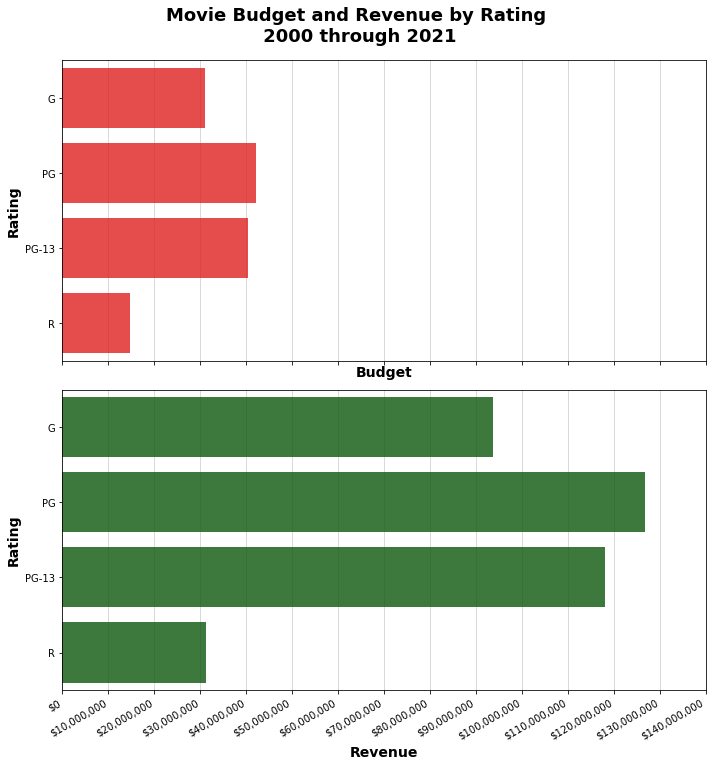

In [20]:
# Import string formatter for labels
from matplotlib.ticker import StrMethodFormatter

# Attempt 1 at comparing budget/revene on rating
fig, axes = plt.subplots(figsize=(10,10), nrows = 2, sharex = True)
plt.suptitle('Movie Budget and Revenue by Rating\n 2000 through 2021', 
             fontsize = 18, weight = 'bold', y = 1.06)
sns.barplot(data = tmdb_viz, x = 'budget', y = 'certification', 
            ci = None, color = "red", alpha = .8, ax = axes[0])
axes[0].set_xlabel('Budget', fontsize=14, weight = 'semibold')
axes[0].set_ylabel('Rating',  fontsize=14, weight = 'semibold')
sns.barplot(data = tmdb_viz, x = 'revenue', y = 'certification', 
            ci = None, color = "#006400", alpha = .8, ax = axes[1])
axes[1].set_xlabel('Revenue', fontsize=14, weight = 'semibold')
axes[1].set_ylabel('Rating',  fontsize=14, weight = 'semibold')
[ax.grid(axis = 'x', alpha = .6) for ax in axes]
[ax.set_axisbelow(True) for ax in axes]
axes[1].xaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
plt.xlim(0,140000000)
plt.xticks(range(0, 141000000, 10000000),rotation = 30, ha = 'right')
fig.tight_layout()

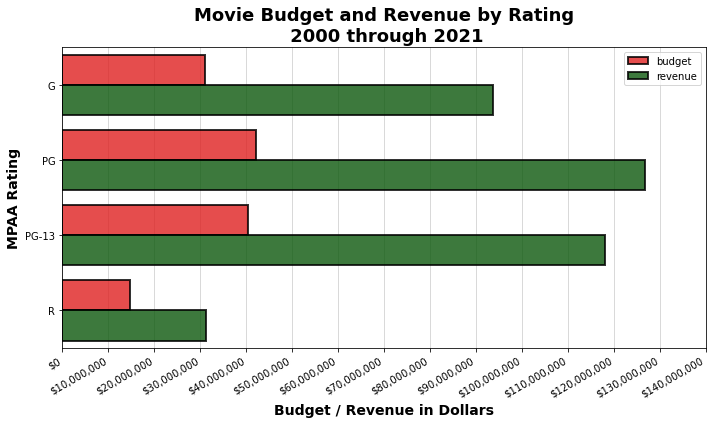

In [21]:
# Attempt 2 at comparing budget/revene on rating
palette ={"budget": "red", "revenue": "#006400"}

fig, axes = plt.subplots(figsize=(10,6), ncols = 1, nrows = 1)
sns.barplot(data = tmdb_viz.melt('certification', 
                                 value_vars = ['budget', 'revenue']),
            x = 'value', y = 'certification', hue = 'variable', 
            palette = palette, alpha = .8, ci = None, 
            edgecolor = 'black', lw = '2', ax = axes)
plt.title('Movie Budget and Revenue by Rating\n 2000 through 2021', 
             fontsize = 18, weight = 'bold')
plt.xlabel('Budget / Revenue in Dollars', fontsize=14, weight = 'semibold')
plt.ylabel('MPAA Rating',  fontsize=14, weight = 'semibold')
axes.grid(axis = 'x', alpha = .6, zorder = 0)
axes.set_axisbelow(True)
axes.xaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
axes.legend(title = None, )
plt.xlim(0,140000000)
plt.xticks(range(0, 141000000, 10000000),rotation = 30, ha = 'right')
fig.tight_layout();

### Viz: Relationship between Budget and Revenue

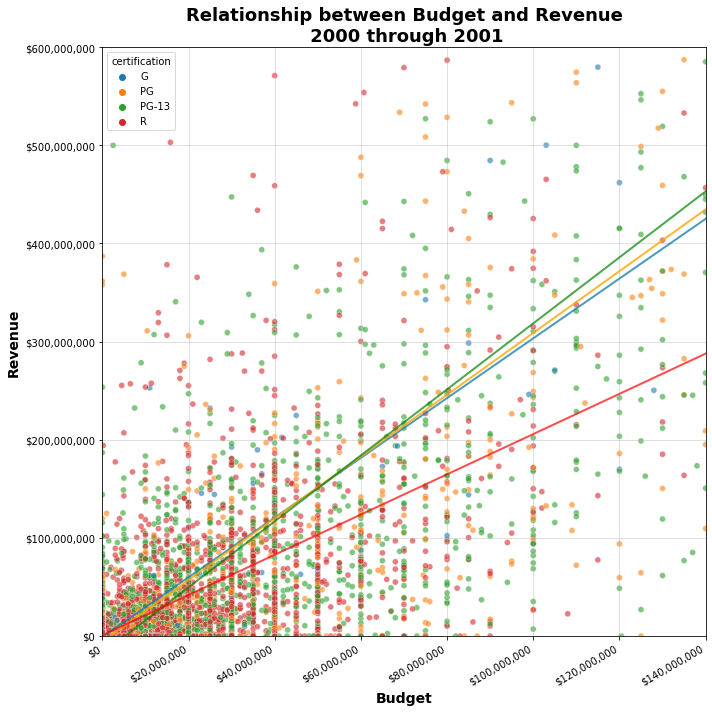

In [22]:
fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(data = tmdb_viz, x = 'budget', y = 'revenue', hue = "certification", alpha = .6);
sns.regplot(data=tmdb_viz[tmdb_viz['certification'] == 'G'], x = 'budget', y = 'revenue', 
            scatter_kws={'s':0}, ci=None,
            line_kws={'color': '#1e81b0', 'lw' : 2, 'alpha' : .8})
sns.regplot(data=tmdb_viz[tmdb_viz['certification'] == 'PG'], x = 'budget', y = 'revenue', 
            scatter_kws={'s':0}, ci=None,
            line_kws={'color': "orange", 'lw' : 2, 'alpha' : .8})
sns.regplot(data=tmdb_viz[tmdb_viz['certification'] == 'PG-13'], x = 'budget', y = 'revenue', 
            scatter_kws={'s':0}, ci=None,
            line_kws={'color': "green", 'lw' : 2, 'alpha' : .7})
sns.regplot(data=tmdb_viz[tmdb_viz['certification'] == 'R'], x = 'budget', y = 'revenue', 
            scatter_kws={'s':0}, ci=None,
            line_kws={'color': "red", 'lw' : 2, 'alpha' : .7})
# sns.regplot(data=tmdb_viz[tmdb_viz['certification'] == 'NR'], x = 'budget', y = 'revenue', 
#             scatter_kws={'s':0}, ci=None,
#             line_kws={'color': "purple", 'lw' : 2, 'alpha' : .7})
# sns.regplot(data=tmdb_viz[tmdb_viz['certification'] == 'NC-17'], x = 'budget', y = 'revenue', 
#             scatter_kws={'s':0}, ci=None,
#             line_kws={'color': "brown", 'lw' : 2, 'alpha' : .7})
plt.title('Relationship between Budget and Revenue\n 2000 through 2001', 
             fontsize = 18, weight = 'bold')
plt.xlabel('Budget', fontsize=14, weight = 'semibold')
plt.ylabel('Revenue',  fontsize=14, weight = 'semibold')
ax.xaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
plt.xlim(0,140000000)
plt.ylim(0,600000000)
plt.grid(alpha = .5)
plt.xticks(rotation = 30, ha = 'right')
fig.tight_layout()

# Appendix
Future graphics for further discovery.

In [23]:
tmdb_merged = pd.read_csv("data/tmdb_merged.csv.gz")

In [24]:
tmdb_merged.columns

Index(['imdb_id', 'adult', 'backdrop_path', 'belongs_to_collection', 'budget',
       'genres', 'homepage', 'id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'certification'],
      dtype='object')

In [25]:
# red_notice = tmdb_merged[tmdb_merged['imdb_id'] == 'tt7991608']
# red_notice['revenue']

In [26]:
tmdb_brett = tmdb_merged.copy()
tmdb_brett = tmdb_brett[tmdb_brett['revenue'] != 0]
tmdb_brett = tmdb_brett[tmdb_brett['budget'] != 0]

nr = tmdb_brett['certification'] == 'NR'
unrated = tmdb_brett['certification'] == 'Unrated'
nc17 = tmdb_brett['certification'] == 'NC-17'

tmdb_brett = tmdb_brett[~(nr | unrated | nc17)]
tmdb_brett.dropna(subset= ['certification'], inplace = True)

tmdb_brett['brett'] = tmdb_brett['revenue']/tmdb_brett['budget']
tmdb_brett.head()

imdb_id  adult                     backdrop_path  belongs_to_collection  \
3   tt0118694    0.0  /n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg                      0   
10  tt0120467    0.0                               NaN                      0   
12  tt0120630    0.0  /t7aJ7hqsMLEoqBJk7yAXxcAVvcz.jpg                      1   
15  tt0120753    0.0  /cXXxi0j9sXFt7LbeajuFoKFqWMu.jpg                      0   
16  tt0120755    0.0  /8XaohdSqoBEWHhW40q2VTdMBrV0.jpg                      1   

         budget                                             genres  \
3      150000.0  [{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...   
10     120000.0  [{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...   
12   45000000.0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
15    8000000.0  [{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...   
16  125000000.0  [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...   

                                homepage       id original_language  \
3   http://www.wkw-inthemoodforlove.com/    843.0                cn   
10                                   NaN  19085.0                en   
12                                   NaN   7443.0                en   
15                                   NaN    318.0                en   
16                                   NaN    955.0                en   

              original_title  ... runtime  \
3                       花樣年華  ...    99.0   
10                    Vulgar  ...    87.0   
12               Chicken Run  ...    84.0   
15  The Million Dollar Hotel  ...   122.0   
16    Mission: Impossible II  ...   123.0   

                                     spoken_languages    status  \
3   [{'english_name': 'Cantonese', 'iso_639_1': 'c...  Released   
10  [{'english_name': 'English', 'iso_639_1': 'en'...  Released   
12  [{'english_name': 'English', 'iso_639_1': 'en'...  Released   
15  [{'english_name': 'English', 'iso_639_1': 'en'...  Released   
16  [{'english_name': 'English', 'iso_639_1': 'en'...  Released   

                                              tagline  \
3   Feel the heat, keep the feeling burning, let t...   
10   Everyone loves a clown... some more than others.   
12  This ain't no chick flick. It's poultry in mot...   
15                    Everyone has something to hide.   
16                       Expect the impossible again.   

                       title video  vote_average  vote_count certification  \
3       In the Mood for Love   0.0           8.1      1860.0            PG   
10                    Vulgar   0.0           5.5        40.0             R   
12               Chicken Run   0.0           6.7      3992.0             G   
15  The Million Dollar Hotel   0.0           5.9       247.0             R   
16    Mission: Impossible II   0.0           6.1      5266.0         PG-13   

        brett  
3   85.699687  
10   0.124200  
12   4.996324  
15   0.013248  
16   4.371105  

[5 rows x 27 columns]

In [27]:
red_notice = tmdb_brett[tmdb_brett['title'].str.contains('Red Notice')]

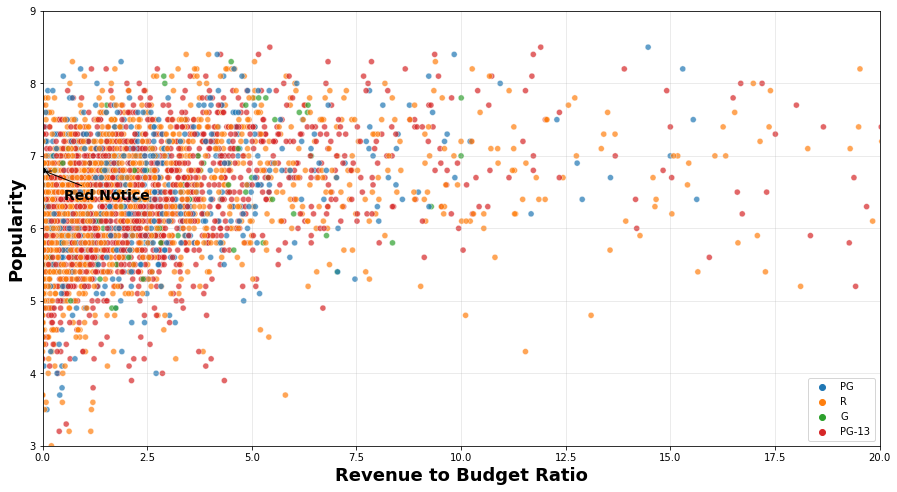

In [32]:
fig, ax = plt.subplots(figsize = (15,8))
sns.scatterplot(data = tmdb_brett, x = tmdb_brett['brett'], y = tmdb_merged['vote_average'],
               hue = 'certification', alpha = .7)
sns.scatterplot(data = tmdb_brett, x = red_notice['brett'], y = red_notice['vote_average'],
               color = 'k', marker = 'o')
plt.xlim(0, 20)
plt.ylim(3,9)
plt.grid(alpha = .3)
plt.ylabel('Popularity', size = 18, weight = 'semibold')
plt.xlabel('Revenue to Budget Ratio',size = 18, weight = 'semibold')
plt.annotate("Red Notice", xy = (red_notice['brett'], red_notice['vote_average']),
         xytext=(red_notice['brett']+.5, red_notice['vote_average']-.4), 
             arrowprops=dict(arrowstyle='->'), size = 14, weight = 'semibold');

In [29]:
drop_list=['adult', 'runtime', 'genres', 'release_date', 'backdrop_path', 'homepage', 
           'tagline', 'poster_path', 'original_title', 'id', 'video', 'overview', 
           'original_language', 'spoken_languages']

tmdb_brett.drop(columns = drop_list, inplace = True)


tmdb_brett.sort_values(by = ['brett'], ascending = False)
# .sort_values(tmdb_brett['brett'], ascending = False)

imdb_id  belongs_to_collection      budget  popularity  \
18657  tt0893412                      0        93.0       9.108   
6798   tt0404802                      0        90.0      11.236   
21803  tt1595656                      0       112.0       9.916   
11366  tt1179904                      1    215000.0      52.274   
32066  tt2309260                      1    100000.0      13.689   
...          ...                    ...         ...         ...   
25407  tt2083231                      0  15000000.0       6.411   
11626  tt0400426                      0  30000000.0       9.656   
8243   tt0429277                      0   2000000.0       2.716   
10679  tt0859760                      0   4002313.0       7.547   
3945   tt0311863                      0  10000000.0       4.547   

                                    production_companies  \
18657  [{'id': 1575, 'logo_path': None, 'name': 'Lewi...   
6798   [{'id': 1512, 'logo_path': None, 'name': 'John...   
21803  [{'id': 37145, 'logo_path': None, 'name': 'Bro...   
11366  [{'id': 3172, 'logo_path': '/kDedjRZwO8uyFhuHa...   
32066  [{'id': 69581, 'logo_path': None, 'name': 'Tre...   
...                                                  ...   
25407  [{'id': 13498, 'logo_path': None, 'name': 'Mar...   
11626  [{'id': 1063, 'logo_path': '/fpVBhNnopOZwGuF0g...   
8243   [{'id': 92534, 'logo_path': None, 'name': 'Zyz...   
10679  [{'id': 6535, 'logo_path': None, 'name': 'Narr...   
3945                                                  []   

                                    production_countries      revenue  \
18657  [{'iso_3166_1': 'US', 'name': 'United States o...    2500000.0   
6798   [{'iso_3166_1': 'US', 'name': 'United States o...    1410778.0   
21803  [{'iso_3166_1': 'US', 'name': 'United States o...     587615.0   
11366  [{'iso_3166_1': 'US', 'name': 'United States o...  194183034.0   
32066  [{'iso_3166_1': 'US', 'name': 'United States o...   42664410.0   
...                                                  ...          ...   
25407  [{'iso_3166_1': 'US', 'name': 'United States o...       1061.0   
11626  [{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...        743.0   
8243   [{'iso_3166_1': 'US', 'name': 'United States o...         30.0   
10679           [{'iso_3166_1': 'MX', 'name': 'Mexico'}]          6.0   
3945                                                  []         10.0   

         status                      title  vote_average  vote_count  \
18657  Released         From Prada to Nada           5.5       279.0   
6798   Released  The Notorious Bettie Page           6.3       116.0   
21803  Released              To the Wonder           5.8       394.0   
11366  Released        Paranormal Activity           6.0      4156.0   
32066  Released                The Gallows           5.0       818.0   
...         ...                        ...           ...         ...   
25407  Released                  Java Heat           5.6        65.0   
11626  Released                    Far Cry           3.7       217.0   
8243   Released                Zyzzyx Road           5.1         8.0   
10679  Released             To Rob a Thief           7.4        73.0   
3945   Released           Stealing Sinatra           5.1        13.0   

      certification         brett  
18657         PG-13  26881.720430  
6798              R  15675.311111  
21803             R   5246.562500  
11366             R    903.176902  
32066             R    426.644100  
...             ...           ...  
25407             R      0.000071  
11626             R      0.000025  
8243              R      0.000015  
10679         PG-13      0.000001  
3945              R      0.000001  

[3764 rows x 13 columns]